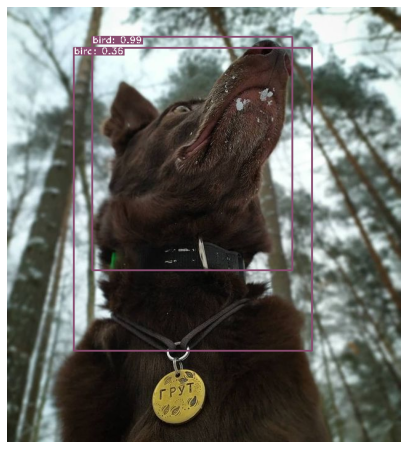

In [1]:
import cv2
import json
from datetime import datetime
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

def id_class_name(class_id, classes):
    for key, value in classes.items():
        if class_id == key:
            return value

# Определяем пост
shortcode = 'CJ8dzDnByFt'

classNames = {}

with open('models/coco2017_labels.txt', 'r+', encoding='utf-8') as file:

    for line in file:
        key = int(line.split(':')[0])
        value = line.split(':')[1]
        classNames[key] = value.strip()
        
COLORS = np.random.uniform(0, 255, size=(len(classNames), 3))

s = requests.session()
r = s.get(f'https://www.instagram.com/p/{shortcode}/?__a=1', headers = {'User-agent': 'bot'})
url = r.json()['graphql']['shortcode_media']['display_resources'][0]['src']

resp = requests.get(url, stream=True)
image = np.asarray(bytearray(resp.content), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
image_height, image_width, _ = image.shape

frame_resized = cv2.resize(image,(300,300))
model = cv2.dnn.readNetFromTensorflow('models/ssd_mobilenet_v2_coco_2018_03_29.pb',
                                      'models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt')
model.setInput(cv2.dnn.blobFromImage(frame_resized, size=(300, 300), swapRB=True))

output = model.forward()
detections = output[0, 0, :, :]
detections = detections[detections[:,2].argsort()]

for detection in detections:

    confidence = detection[2]
    class_id = int(detection[1])
    class_name = id_class_name(class_id, classNames)

    if (confidence > 0.3):

        box_x =      int(detection[3] * image_width)
        box_y =      int(detection[4] * image_height)
        box_width =  int(detection[5] * image_width)
        box_height = int(detection[6] * image_height)

        cv2.rectangle(image, (box_x, box_y), (box_width, box_height), COLORS[class_id], thickness=2)

        label = class_name + ": " + str(round(confidence, 2))
        labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_DUPLEX, 0.5, 1)
        yLeftBottom_ = max(box_y, labelSize[1])

        cv2.rectangle(image, (box_x, box_y + labelSize[1]), (box_x + labelSize[0], box_y), COLORS[class_id], cv2.FILLED)
        cv2.putText(image, label, (box_x, box_y + labelSize[1] - baseLine//2), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.savefig(f'{shortcode}.png')